In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind

# Loading the dataset

In [2]:
conn=sqlite3.connect('pharma.db')
df=pd.read_sql_query("SELECT * FROM doctors_summary",conn)
df.head()

,doctor_name,specialization,medicine_name,category,company_name,times_prescribed,unit_price,estimated_revenue,doctor_pref_score,avg_cost_per_prescription
0,Dr. GMPJA,Orthopedic,Med_134,Antibiotic,PharmaCo_15,4,986.37,3945.48,0.063486,986.37
1,Dr. VKRVZ,Orthopedic,Med_134,Antibiotic,PharmaCo_15,4,986.37,3945.48,0.066606,986.37
2,Dr. FITJT,Neurologist,Med_92,Statin,PharmaCo_17,4,933.21,3732.84,0.076206,933.21
3,Dr. DOIOO,Neurologist,Med_60,Antidepressant,PharmaCo_19,4,869.95,3479.80,0.052957,869.95
4,Dr. BGWLU,Orthopedic,Med_241,Painkiller,PharmaCo_0,3,990.55,2971.65,0.051998,990.55


In [3]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
times_prescribed,16963.0,1.179037,0.434025,1.000000,1.000000,1.000000,1.000000,6.000000
unit_price,16963.0,521.657344,278.710577,54.810000,279.950000,536.490000,772.750000,990.550000
estimated_revenue,16963.0,614.685048,415.420541,54.810000,301.940000,565.560000,824.690000,3945.480000
doctor_pref_score,16963.0,0.011790,0.008031,0.000779,0.005764,0.010917,0.015779,0.076206
avg_cost_per_prescription,16963.0,521.657344,278.710577,54.810000,279.950000,536.490000,772.750000,990.550000


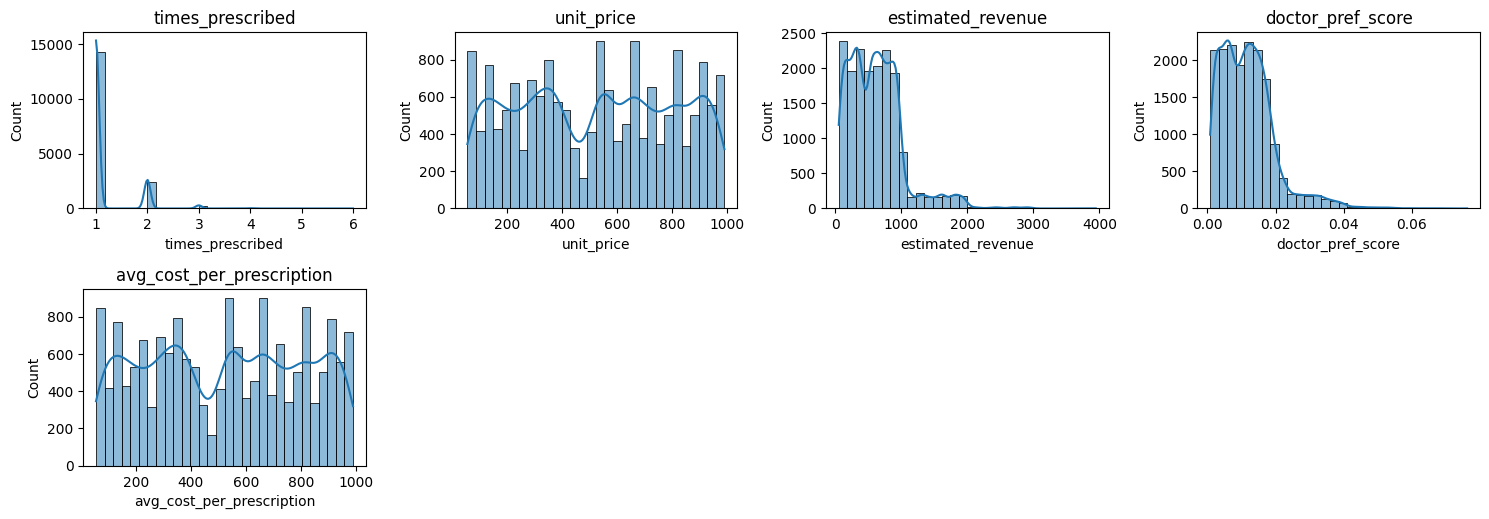

In [4]:
numerical_cols=df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

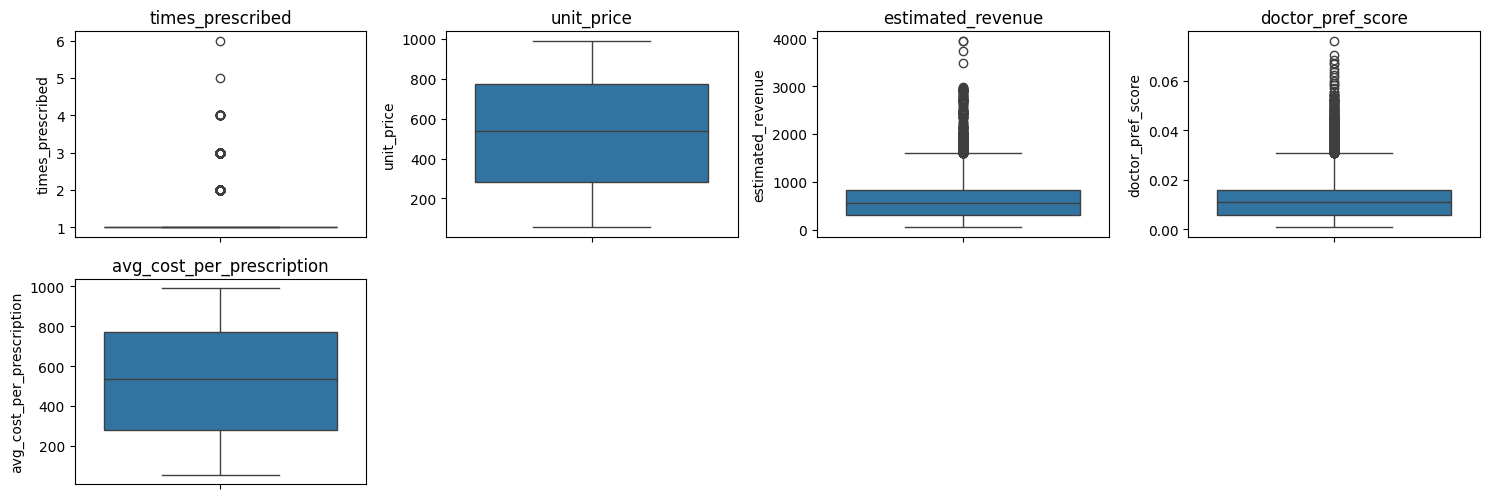

In [5]:
# Outliers Detection with Boxplots
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

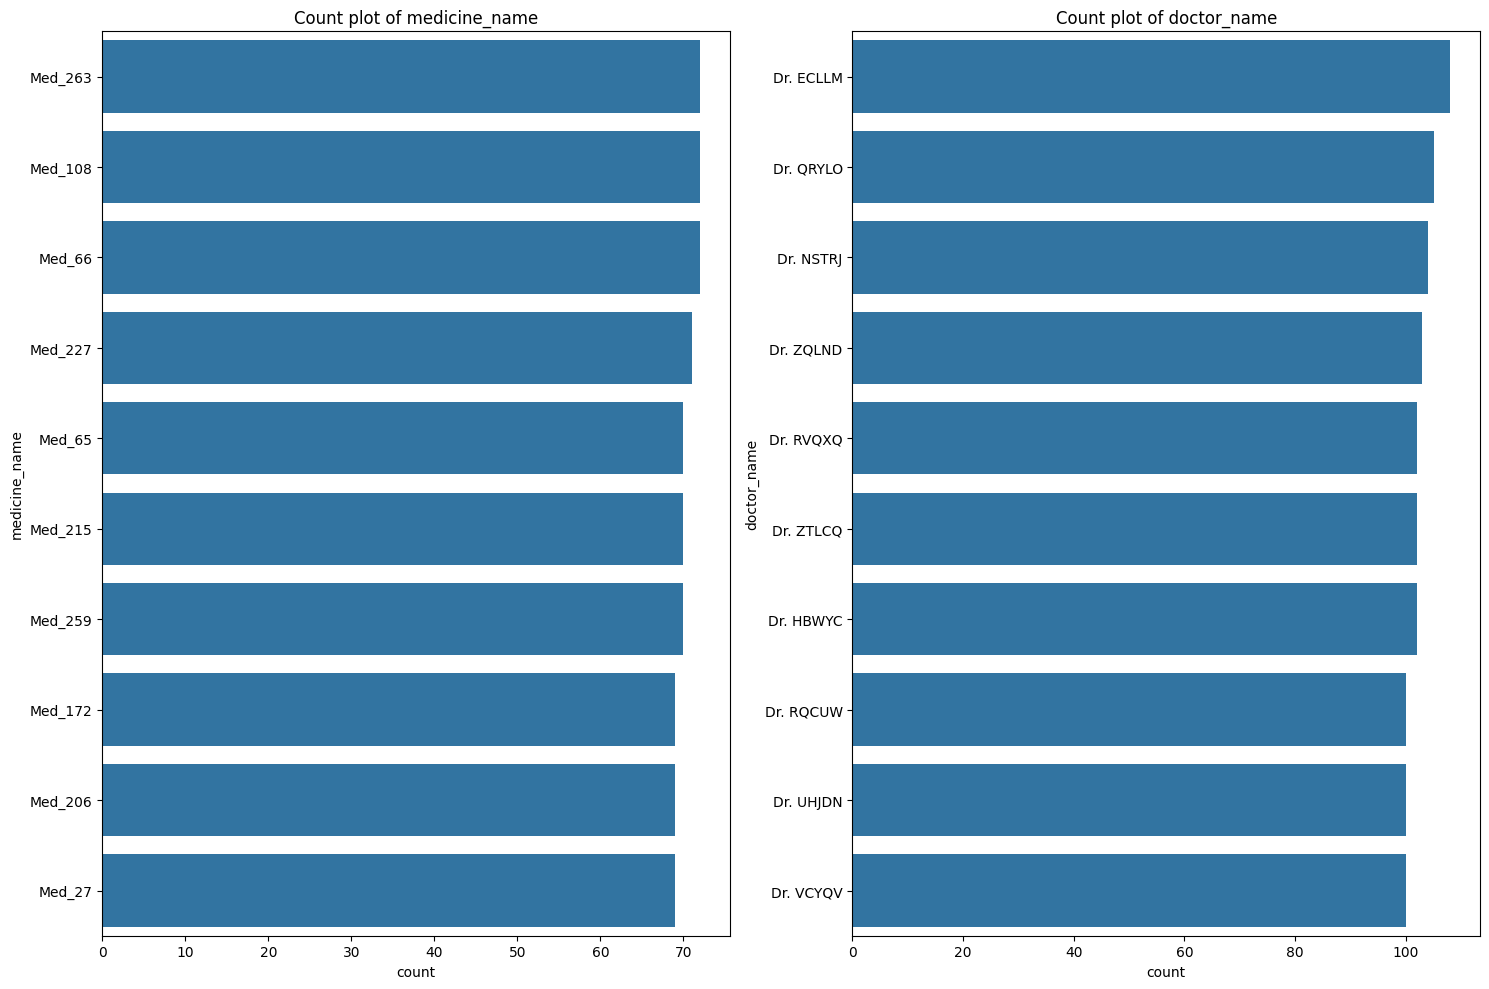

In [6]:
categorical_cols=["medicine_name","doctor_name"]
plt.figure(figsize=(15,10))
for i,col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10])
    plt.title(f"Count plot of {col}")
plt.tight_layout()
plt.show()

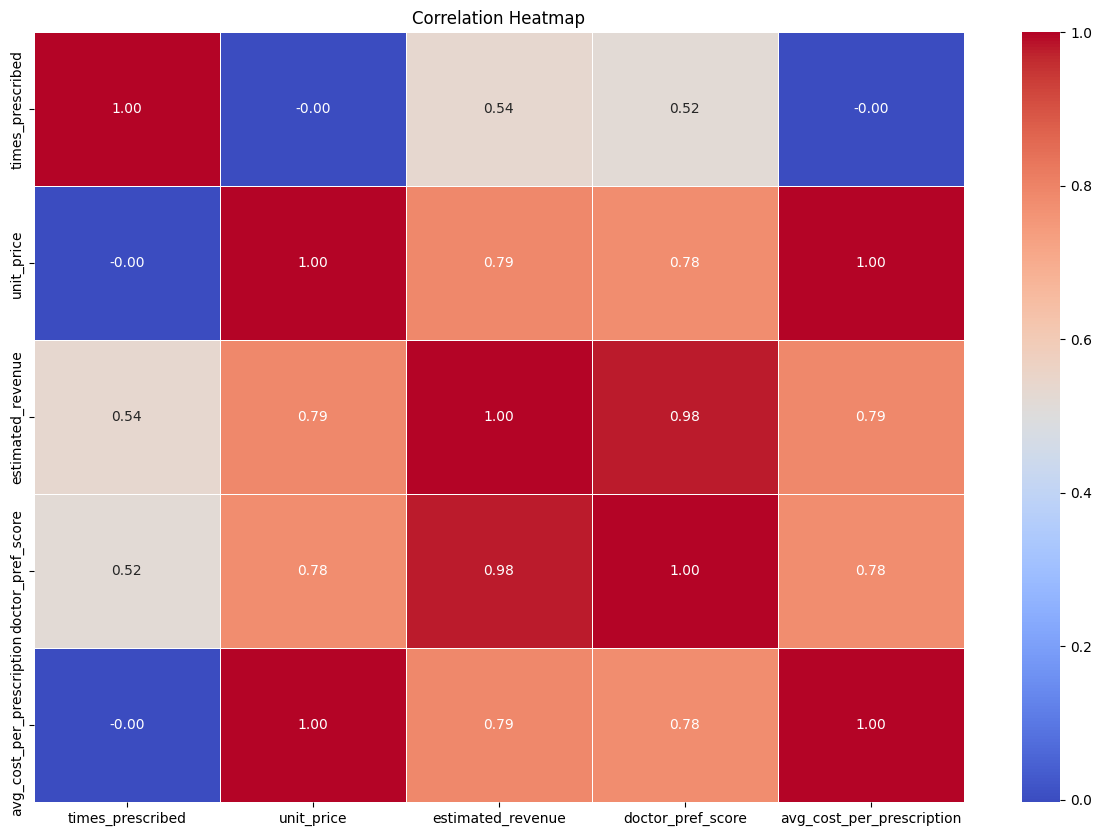

In [7]:
plt.figure(figsize=(15,10))
correlation_matrix= df[numerical_cols].corr()
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Correlation Insights:
These metrics are strongly positively correlated — which makes sense:

Higher unit price → Higher revenue.

Higher revenue → Higher doctor preference score (as it's based on revenue share).

Average cost per prescription naturally scales with both price and revenue.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7884\669623986.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="specialization", y="estimated_revenue", estimator=sum, ci=None)


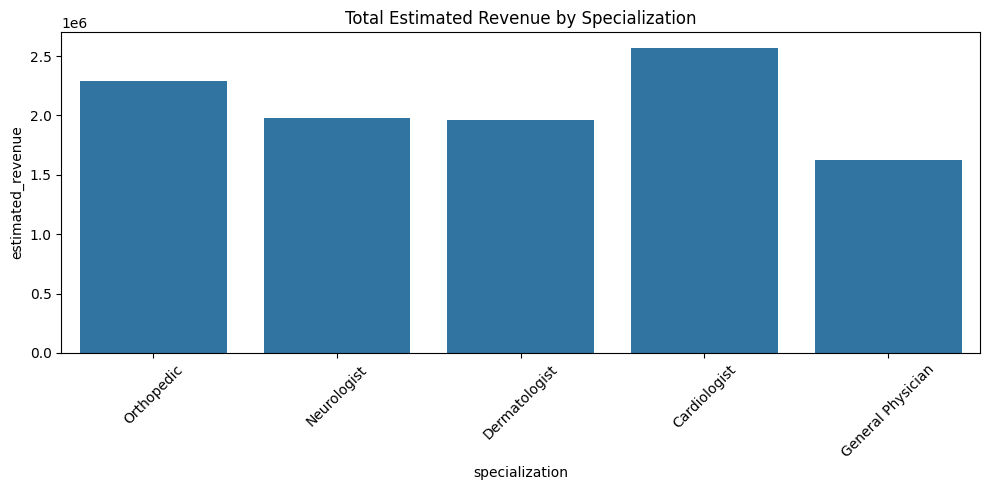

In [8]:
df.groupby("specialization")["estimated_revenue"].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="specialization", y="estimated_revenue", estimator=sum, ci=None)
plt.title("Total Estimated Revenue by Specialization")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insights

# Basic Descriptive Statistics

In [11]:
df[["unit_price", "estimated_revenue", "doctor_pref_score", "times_prescribed"]].describe(percentiles=[.25, .5, .75, .9])

,unit_price,estimated_revenue,doctor_pref_score,times_prescribed
count,16963.000000,16963.000000,16963.000000,16963.000000
mean,521.657344,614.685048,0.011790,1.179037
std,278.710577,415.420541,0.008031,0.434025
min,54.810000,54.810000,0.000779,1.000000
25%,279.950000,301.940000,0.005764,1.000000
50%,536.490000,565.560000,0.010917,1.000000
75%,772.750000,824.690000,0.015779,1.000000
90%,903.630000,984.640000,0.020348,2.000000
max,990.550000,3945.480000,0.076206,6.000000


In [18]:
# 4 quantiles: Q1 (Low), Q2, Q3, Q4 (High)
df["price_segment"] = pd.qcut(df["unit_price"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])
df["revenue_segment"] = pd.qcut(df["estimated_revenue"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])
df["loyalty_segment"] = pd.qcut(df["doctor_pref_score"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])
df["price_segment"].value_counts()

price_segment
Mid-High    4285
Low         4267
Mid-Low     4221
High        4190
Name: count, dtype: int64

In [16]:
df["revenue_segment"].value_counts()

revenue_segment
Low         4252
Mid-High    4247
High        4233
Mid-Low     4231
Name: count, dtype: int64

In [17]:
df["loyalty_segment"].value_counts()

loyalty_segment
Low         4241
Mid-Low     4241
High        4241
Mid-High    4240
Name: count, dtype: int64

Text(0.5, 1.0, 'Doctor-Medicine Pairs by Revenue Segment')

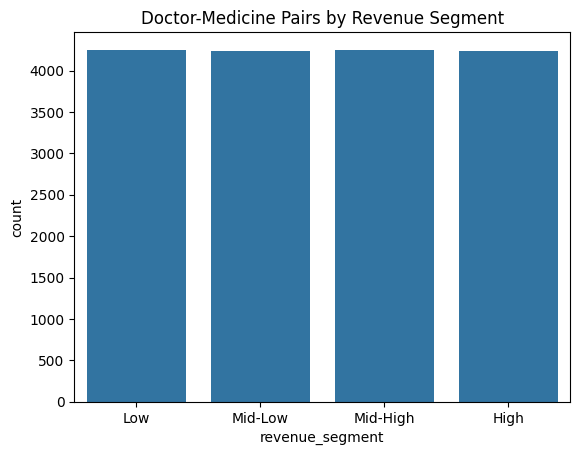

In [19]:
sns.countplot(data=df, x="revenue_segment", order=["Low", "Mid-Low", "Mid-High", "High"])
plt.title("Doctor-Medicine Pairs by Revenue Segment")

# Summary

In [ ]:
 Revenue by Specialization:
Orthopedic and Neurologist doctors generated the highest revenue.

Orthopedics tend to prescribe high-cost painkillers and antibiotics.

 Top Medicines & Companies:
Med_134 and Med_92 topped in revenue.

PharmaCo_15 emerged as the highest-earning pharma company.

 Doctor Preference Score (DPS):
Some doctors showed strong loyalty (DPS > 0.07) to specific medicines.

Useful to target doctors who consistently prescribe high-value drugs.

️⃣ Unit Price Impact:
Strong positive correlation between unit_price and estimated_revenue.

Indicates that price is a more powerful revenue driver than volume.

️⃣ Correlation Heatmap Insights:
estimated_revenue correlated highly with unit_price (0.79) and DPS (0.98).

Very little correlation between times_prescribed and unit_price.

 Quantile Analysis:
Top 25% (Q4) of records contributed majority of the revenue.
Segmenting by revenue, loyalty, and unit price revealed key performers.
Created a Doctor-Medicine Gold Segment: High Revenue + High Loyalty

 Threshold Analysis:
Used dynamic quantiles (not hardcoded values) to flag:
High-price medicines (Q4 of unit_price)
High-loyalty doctors (Q4 of doctor_pref_score)
Elite performers (Top 10% by revenue)